<div style="text-align: right"> Brian Wiley <br/>
EN.705.601.3VL.SP20 Applied Machine Learning </div>

## Assignment 12
### Applied Machine Learning



__1. [10 pts] Pre-process the dataset, apply normalization or standardization, list number of rows and columns, check sanity.__

In [1]:
import pandas as pd
import numpy as np

In [2]:
path = 'datasets/'
df = pd.read_csv(path + 'creditcard.csv')

In [3]:
print(df.head())
print(df.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
X = df.loc[:, df.columns != "Class"]
y = df.loc[:, df.columns == "Class"].values.ravel()

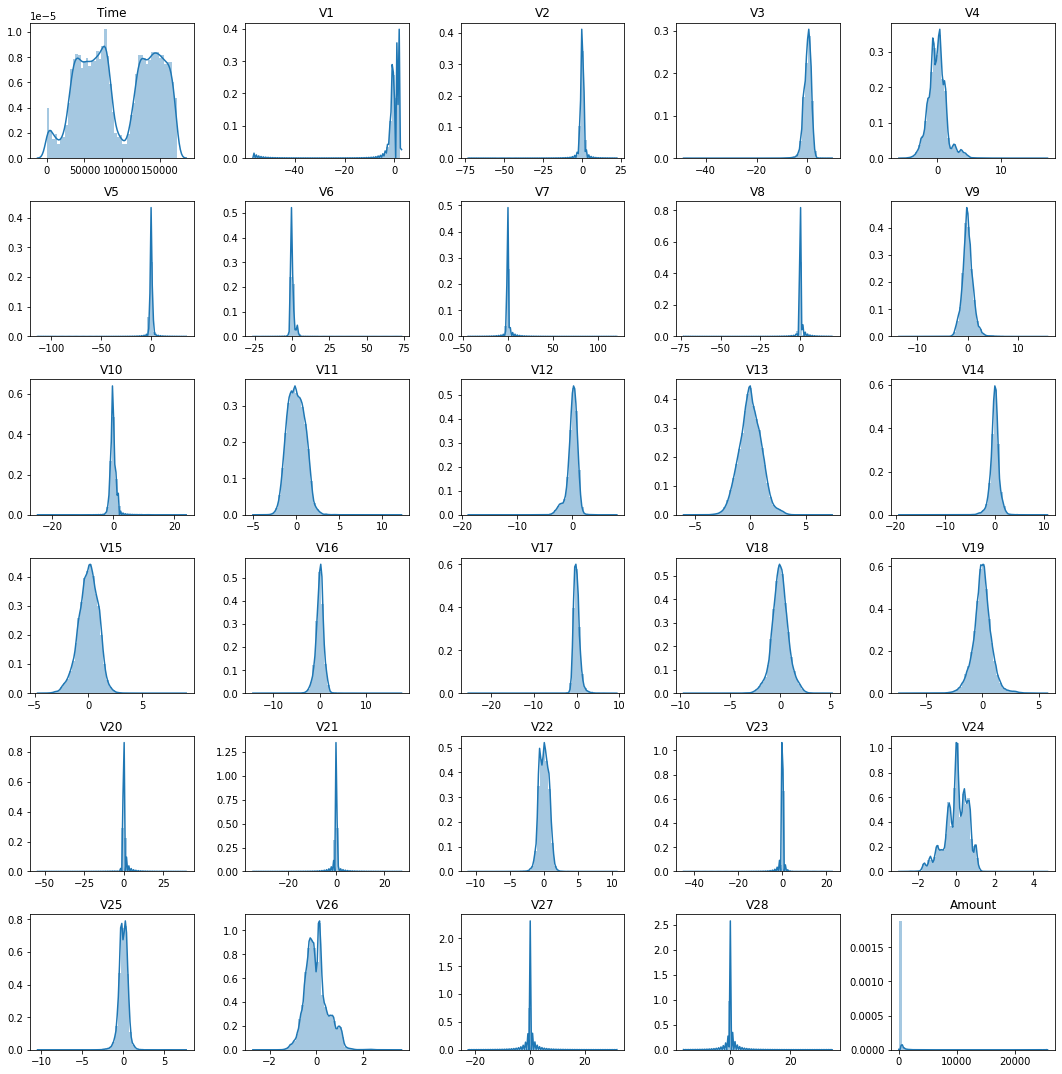

In [5]:
## plot before normalizatiion/standardization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize=(15, 15), nrows=6, ncols=5)

axs = axs.flatten()
for i in range(30):
    sns.distplot(X.iloc[:, i], ax=axs[i])
    axs[i].set_title(X.columns[i])
    axs[i].set_xlabel(None)

fig.tight_layout(pad=1.0)
plt.show()

#### As you can see above most of the columns are already normalized.  The only columns that are not are `time` and `amount` columns, so the PCA columns might have been normalized before or after doing PCA, i.e. the pipeline for PCA include normalization somewhere.  But we will normalize it all anyway.

Here I will try both normalization and min-max [0-1] standardization.

In [6]:
## from pandas API - 0 or ‘index’: apply function to each column.
## normalization
X_norm = X.apply(lambda x: (x-x.mean())/x.std(), axis=0)

## min-max of [0-1] standardization: https://en.wikipedia.org/wiki/Feature_scaling
X_stand = X.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)

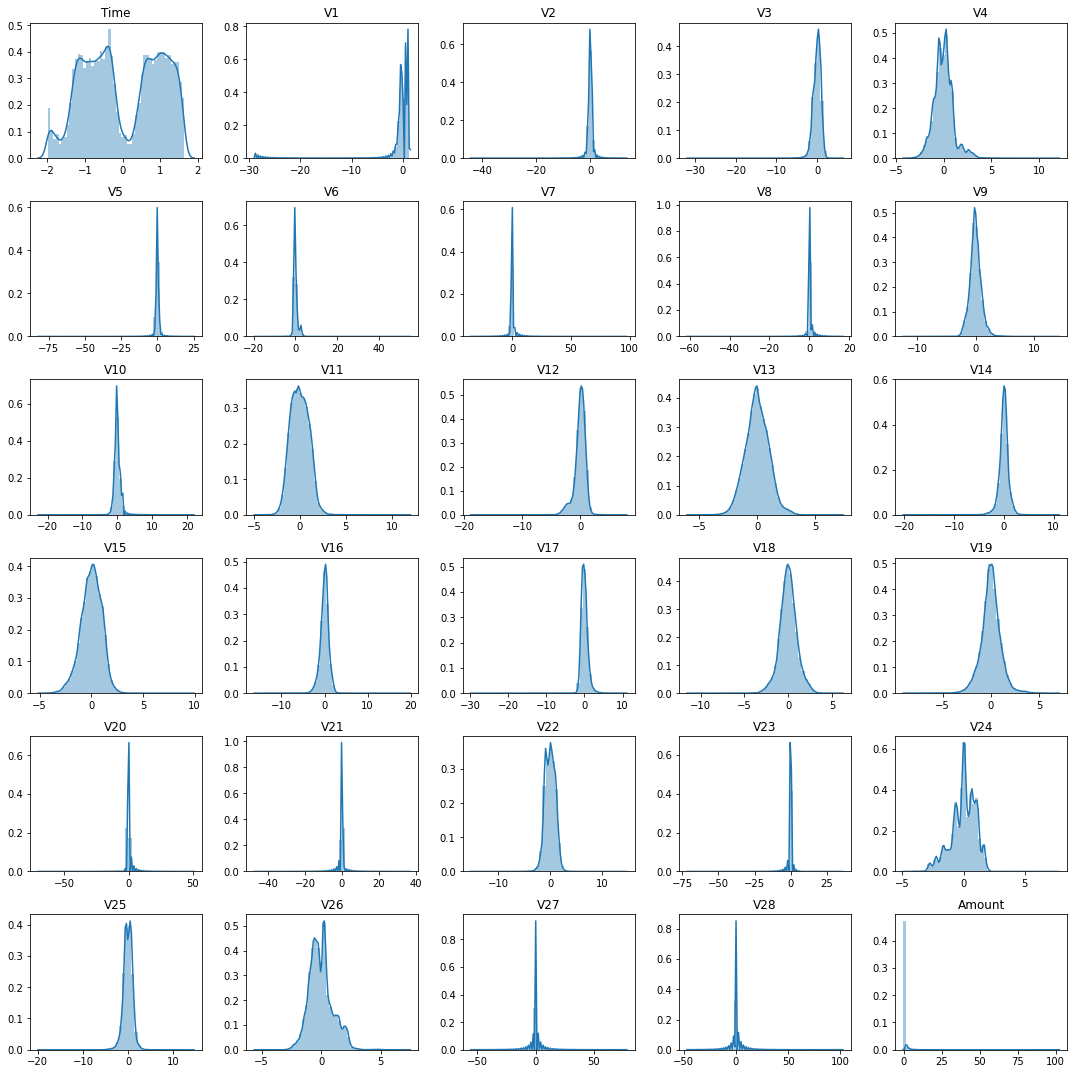

In [7]:
## plot after normalization
fig, axs = plt.subplots(figsize=(15, 15), nrows=6, ncols=5)

axs = axs.flatten()
for i in range(30):
    sns.distplot(X_norm.iloc[:, i], ax=axs[i])
    axs[i].set_title(X.columns[i])
    axs[i].set_xlabel(None)

fig.tight_layout(pad=1.0)
plt.show()

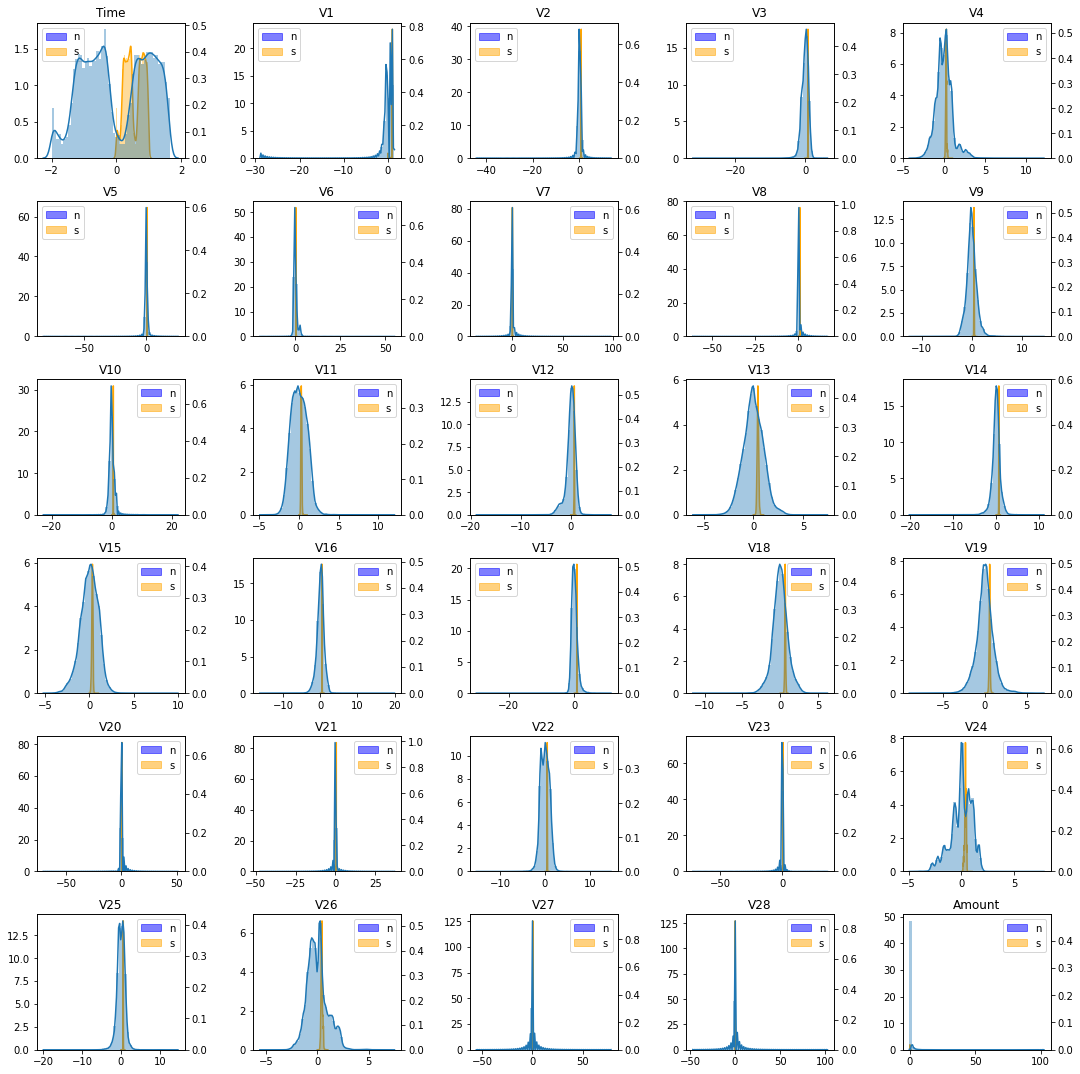

In [8]:
## plot after standardization with overlay of the normalization
import matplotlib.patches as mpatches

fig, axs = plt.subplots(figsize=(15, 15), nrows=6, ncols=5)

axs = axs.flatten()
for i in range(30):
    sns.distplot(X_stand.iloc[:, i], ax=axs[i], color='orange', label='s')
    ax_twin = axs[i].twinx()
    sns.distplot(X_norm.iloc[:, i], ax=ax_twin, label='n')
    axs[i].set_title(X.columns[i])
    axs[i].set_xlabel(None)
    blue_patch = mpatches.Patch(label='n', color='blue', alpha=0.5)
    orange_patch = mpatches.Patch(label='s', color='orange', alpha=0.5)
    axs[i].legend(handles=[blue_patch, orange_patch], loc='best')
    #axs[i].legend(loc='best')
    #ax_twin.legend(loc='best')
    

fig.tight_layout(pad=1.0)
plt.show()

__2. [10 pts] Check the class balance and pick an evaluation metric__

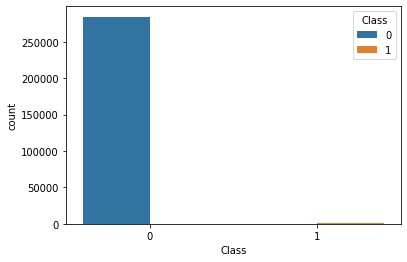

In [9]:
## just to see the inbalance of class.
sns.countplot(x='Class', hue='Class', data=df.loc[:, df.columns == "Class"])

__3. [20 pts] Split the dataset 50-50 for training and testing. Then run DecisionTreeClassifier, SVC, MLPClassifier without any tree pruning or regularization. Report your classification accuracy.__

So we can run a 50/50 split by make KFold of 2 splits.  It really running a 50/50 split twice.  Train on 50% and test 50% and then train on the test and test on the train.

In [10]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler ## just use sklearn's normalization API as well
from sklearn.preprocessing import MinMaxScaler ## just use sklearn's min-max [0-1] API as well
from sklearn.pipeline import make_pipeline, Pipeline

## for 50/50 split train test can do CV=2
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=41)

## Run with no tree pruning or regularization
DTC_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])


accuracies_DTC = cross_validate(DTC_pipeline, X_norm, y, cv=kfold, scoring=['average_precision', 'f1'])
for k, v in accuracies_DTC.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'DecisionTreeClassifier 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

DecisionTreeClassifier 50/50 cross validation test_average_precision is 0.594 ±0.0108
DecisionTreeClassifier 50/50 cross validation test_f1 is 0.770 ±0.0071
Wall time: 27.9 s


In [11]:
accuracies_DTC

{'fit_time': array([14.93006945, 12.07198381]),
 'score_time': array([0.19716358, 0.17549944]),
 'test_average_precision': array([0.58365312, 0.60532408]),
 'test_f1': array([0.76320939, 0.77731092])}

In [12]:
%%time
from sklearn.exceptions import ConvergenceWarning ## doesn't work
ConvergenceWarning('ignore') ## doesn't work
from  warnings import simplefilter ## works
simplefilter("ignore", category=ConvergenceWarning) ## works

## Run with no tree pruning of regularization
LinearSVC_pipeline = Pipeline([
    ('classifier', LinearSVC())
])

accuracies_LSVC = cross_validate(LinearSVC_pipeline, X_norm, y, cv=kfold, scoring=['average_precision', 'f1'])
for k, v in accuracies_LSVC.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearSVC_pipeline 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

LinearSVC_pipeline 50/50 cross validation test_average_precision is 0.762 ±0.0089
LinearSVC_pipeline 50/50 cross validation test_f1 is 0.803 ±0.0087
Wall time: 1min 28s


In [13]:
%%time
## Run with no tree pruning of regularization
MLP_pipeline = Pipeline([
    ('classifier', MLPClassifier())
])

accuracies_MLP = cross_validate(MLP_pipeline, X_norm, y, cv=kfold, scoring=['average_precision', 'f1'])
for k, v in accuracies_LSVC.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'MLP_pipeline 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

MLP_pipeline 50/50 cross validation test_average_precision is 0.762 ±0.0089
MLP_pipeline 50/50 cross validation test_f1 is 0.803 ±0.0087
Wall time: 58 s


__4. [20 pts] Run DecisionTreeClassifier, SVC, MLPClassifier with tree pruning and regularization. Report your classification accuracy.__

In [14]:
%%time
## Run with tree pruning and/or regularization

ccp_alpha = np.arange(.001, .006, .001)
param_grid_DTC_Pruning = dict(classifier__ccp_alpha=ccp_alpha)

grid_DTC_Prun = GridSearchCV(DTC_pipeline, 
                             param_grid=param_grid_DTC_Pruning, 
                             cv=kfold, n_jobs=1, verbose=0, 
                             scoring=['average_precision', 'f1'],
                             refit='average_precision')

grid_DTC_Prun.fit(X_norm, y)
grid_DTC_Prun.best_params_

Wall time: 2min 42s


{'classifier__ccp_alpha': 0.001}

The higher you make `ccp_alpha` it makes the results worse pretty fast.  Best result was with the lowest `ccp_alpha`.  I tried a test earlier with `ccp_alpha` being .05 and the f1 was less than 1%.

In [15]:
ccp_alpha = grid_DTC_Prun.best_params_['classifier__ccp_alpha'] 

DTC_pipeline_Pruning = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
accuracies_DTC_Pruning = cross_validate(DTC_pipeline_Pruning, X_norm, y, cv=kfold, scoring=['average_precision', 'f1'])
for k, v in accuracies_DTC_Pruning.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'DecisionTreeClassifier with pruning 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
print()

for k, v in accuracies_DTC.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'DecisionTreeClassifier without pruning 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

DecisionTreeClassifier with pruning 50/50 cross validation test_average_precision is 0.516 ±0.0023
DecisionTreeClassifier with pruning 50/50 cross validation test_f1 is 0.717 ±0.0002

DecisionTreeClassifier without pruning 50/50 cross validation test_average_precision is 0.594 ±0.0108
DecisionTreeClassifier without pruning 50/50 cross validation test_f1 is 0.770 ±0.0071


Now run different hyperparameters for `C` for LinearSVC and then run with best one for 50/50 split.

In [30]:
np.concatenate((np.array(np.logspace(-4, 1, 6)), np.array([5.0])))

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 5.e+00])

In [17]:
%%time
## Find best LinearSVC with tree pruning and/or regularization

param_grid_LinearSVC_Reg = dict(classifier__C=np.logspace(-3, 1, 5))

grid_LinearSVC_Prun = GridSearchCV(LinearSVC_pipeline, 
                                   param_grid=param_grid_LinearSVC_Reg, 
                                   cv=kfold, n_jobs=1, verbose=0, 
                                   scoring='f1')

grid_LinearSVC_Prun.fit(X_norm, y)
grid_LinearSVC_Prun.best_params_

Wall time: 6min 6s


{'classifier__C': 10.0}

Out of the following parameters for C, `array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 5.e+00])` it looks like 10.0 was best. 

In [18]:
## Run with LinearSVC tree pruning and/or regularization
C=grid_LinearSVC_Prun.best_params_['classifier__C']

LinearSVC_Reg = LinearSVC(C=5)
accuracies_LSVC_Reg = cross_validate(LinearSVC_Reg, X_norm, y, cv=kfold, scoring=['average_precision', 'f1'])
for k, v in accuracies_LSVC_Reg.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearSVC_pipeline with regularization 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
print()

for k, v in accuracies_LSVC.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'LinearSVC_pipeline without regularization 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

LinearSVC_pipeline with regularization 50/50 cross validation test_average_precision is 0.749 ±0.0142
LinearSVC_pipeline with regularization 50/50 cross validation test_f1 is 0.819 ±0.0084

LinearSVC_pipeline without regularization 50/50 cross validation test_average_precision is 0.762 ±0.0089
LinearSVC_pipeline without regularization 50/50 cross validation test_f1 is 0.803 ±0.0087


Now find best value of hidden layer neuron pruning and the l2 regularization for alpha parameter.

In [19]:
%%time
## Find best paramas with tree pruning and/or regularization
## Here having hidden layer of lower sizes is a type of tree pruning/neuron pruning

MLP_pipeline_Reg = Pipeline([
    ('classifier', MLPClassifier())
])

## make hidden layers less than default (100,)
param_grid_MLP_Pruning = dict(classifier__hidden_layer_sizes=[(20, 20), (20, 10), (10, 10)],
                              classifier__alpha=np.logspace(-6, -3, 4)
                             )
                        

grid_MLP_Prun = GridSearchCV(MLP_pipeline_Reg, 
                             param_grid=param_grid_MLP_Pruning, 
                             cv=kfold, n_jobs=1, verbose=0, 
                             scoring=['average_precision', 'f1'],
                             refit='average_precision')

grid_MLP_Prun.fit(X_norm, y)
grid_MLP_Prun.best_params_

Wall time: 7min 31s


{'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (20, 10)}

In [20]:
hidden_layer_sizes = grid_MLP_Prun.best_params_['classifier__hidden_layer_sizes'] 
l2_alpha = grid_MLP_Prun.best_params_['classifier__alpha'] 


MLP_pipeline_Pruning_Reg = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                         alpha=l2_alpha)
accuracies_MLP_Pruning = cross_validate(MLP_pipeline_Pruning_Reg, X_norm, y, cv=kfold, scoring=['average_precision', 'f1'])
for k, v in accuracies_MLP_Pruning.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'MLP with nueron pruning and l2 regularization 50/50 cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')
print()

for k, v in accuracies_MLP.items():
    if (k != 'fit_time' and k != 'score_time'):
        print(f'MLP_pipeline 50/50 without regularization cross validation {k} is {np.mean(v):.3f} {chr(177)}{np.std(v):.4f}')

MLP with nueron pruning and l2 regularization 50/50 cross validation test_average_precision is 0.811 ±0.0247
MLP with nueron pruning and l2 regularization 50/50 cross validation test_f1 is 0.806 ±0.0141

MLP_pipeline 50/50 without regularization cross validation test_average_precision is 0.832 ±0.0233
MLP_pipeline 50/50 without regularization cross validation test_f1 is 0.837 ±0.0223


__5. [20 pts] Add splits 60-40, 70-30, 80-20, 90-10, 95-5 and repeat step 3 and step 4.__

In [32]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_size_split = [50, 60, 70, 80, 90, 95]

f1_DCT = []
f1_DCT_prun = []
f1_LinSVC = []
f1_LinSVC_reg = []
f1_MLP = []
f1_MLP_prune_reg = []

## Going to use sklearn's StandardScaler for the training and testing
for train_size in train_size_split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size/100, shuffle=True, random_state=0)
    
    ## DTC no pruning
    DTC_pipeline_ = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', DecisionTreeClassifier())
    ])
    DTC_pipeline_.fit(X_train, y_train)
    DTC_y_pred = DTC_pipeline_.predict(X_test)
    f1_DCT.append(f1_score(y_test, DTC_y_pred))
    
    ## DTC pruning
    ## ccp_alpha = 0.001
    DTC_pipeline_Prune = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', DecisionTreeClassifier(ccp_alpha=ccp_alpha))
    ])
    DTC_pipeline_Prune.fit(X_train, y_train)
    DTC_prune_y_pred = DTC_pipeline_Prune.predict(X_test)
    f1_DCT_prun.append(f1_score(y_test, DTC_prune_y_pred))
    
    
    ## LinearSVC no regularization
    LinearSVC_pipeline_ = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', LinearSVC())
    ])
    LinearSVC_pipeline_.fit(X_train, y_train)
    LinearSVC_y_pred = LinearSVC_pipeline_.predict(X_test)
    f1_LinSVC.append(f1_score(y_test, LinearSVC_y_pred))
    
    ## LinearSVC regularization, C=10.0
    LinearSVC_pipeline_Reg = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', LinearSVC(C=C))
    ])
    LinearSVC_pipeline_Reg.fit(X_train, y_train)
    LinearSVC_reg_y_pred = LinearSVC_pipeline_Reg.predict(X_test)
    f1_LinSVC_reg.append(f1_score(y_test, LinearSVC_reg_y_pred))

    
    ## MLP no pruning, default hidden_layer_sizes (100,)
    MLP_pipeline_ = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', MLPClassifier())
    ])
    MLP_pipeline_.fit(X_train, y_train)
    MLP_y_pred = MLP_pipeline_.predict(X_test)
    f1_MLP.append(f1_score(y_test, MLP_y_pred))
    
    ## MLP neuron pruning and regularization 
    ## hidden_layer_sizes: (20, 10) and l2: 0.001
    MLP_pipeline_Prune_Reg = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                     alpha=l2_alpha))
    ])
    MLP_pipeline_Prune_Reg.fit(X_train, y_train)
    MLP_prune_reg_y_pred = MLP_pipeline_Prune_Reg.predict(X_test)
    f1_MLP_prune_reg.append(f1_score(y_test, MLP_prune_reg_y_pred))

Wall time: 23min 21s


__6. [20 pts] Plot everything you have on a single plot and comment about your results in terms of training size, regularization, etc.__

In [33]:
df_scoring = pd.DataFrame({'Train_Size %': train_size_split,
                           'DTC_f1': f1_DCT,
                           'DTC_f1_with_pruning': f1_DCT_prun,
                           'LinSVC_f1': f1_LinSVC,
                           'LinSVC_f1_regular': f1_LinSVC_reg,
                           'MLP_f1': f1_MLP,
                           'MLP_f1_neuronPruning_regular': f1_MLP_prune_reg
                          })

In [38]:
df_scoring

,Train_Size %,DTC_f1,DTC_f1_with_pruning,LinSVC_f1,LinSVC_f1_regular,MLP_f1,MLP_f1_neuronPruning_regular
0,50,0.745763,0.719486,0.787330,0.808511,0.841163,0.843956
1,60,0.744304,0.725849,0.786704,0.818414,0.833773,0.845528
2,70,0.759582,0.707143,0.780303,0.807143,0.815331,0.804781
3,80,0.801980,0.714286,0.802139,0.824742,0.849741,0.840426
4,90,0.771930,0.763636,0.704545,0.818182,0.788462,0.803922
5,95,0.806452,0.741935,0.862069,0.833333,0.785714,0.819672


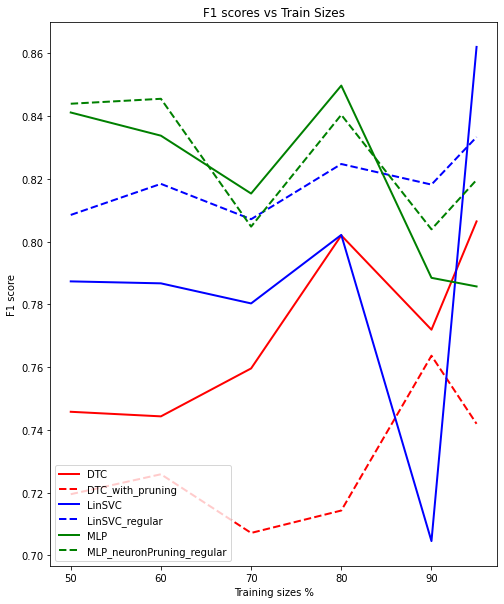

In [39]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(111)
ax.plot(df_scoring['Train_Size %'], df_scoring['DTC_f1'], linestyle='-', linewidth=2, color='red', label='DTC')
ax.plot(df_scoring['Train_Size %'], df_scoring['DTC_f1_with_pruning'], linestyle='--', linewidth=2, color='red', label='DTC_with_pruning')

ax.plot(df_scoring['Train_Size %'], df_scoring['LinSVC_f1'], linestyle='-', linewidth=2, color='blue', label='LinSVC')
ax.plot(df_scoring['Train_Size %'], df_scoring['LinSVC_f1_regular'], linestyle='--', linewidth=2, color='blue', label='LinSVC_regular')

ax.plot(df_scoring['Train_Size %'], df_scoring['MLP_f1'], linestyle='-', linewidth=2, color='green', label='MLP')
ax.plot(df_scoring['Train_Size %'], df_scoring['MLP_f1_neuronPruning_regular'], linestyle='--', linewidth=2, color='green', label='MLP_neuronPruning_regular')

ax.set_xlabel('Training sizes %')
ax.set_ylabel('F1 score')
ax.set_title('F1 scores vs Train Sizes')
ax.legend(loc='best')


Text(0.5, 1.0, 'MLPClassifier')

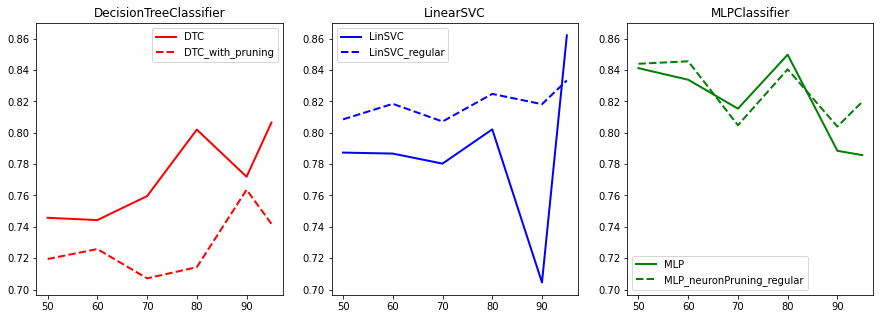

In [40]:
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(131)
ax.plot(df_scoring['Train_Size %'], df_scoring['DTC_f1'], linestyle='-', linewidth=2, color='red', label='DTC')
ax.plot(df_scoring['Train_Size %'], df_scoring['DTC_f1_with_pruning'], linestyle='--', linewidth=2, color='red', label='DTC_with_pruning')
ax.legend(loc='best')
ax.set_title('DecisionTreeClassifier')

ax2 = plt.subplot(132, sharey=ax)
ax2.plot(df_scoring['Train_Size %'], df_scoring['LinSVC_f1'], linestyle='-', linewidth=2, color='blue', label='LinSVC')
ax2.plot(df_scoring['Train_Size %'], df_scoring['LinSVC_f1_regular'], linestyle='--', linewidth=2, color='blue', label='LinSVC_regular')
ax2.legend(loc='best')
ax2.set_title('LinearSVC')


ax3 = plt.subplot(133, sharey=ax)
ax3.plot(df_scoring['Train_Size %'], df_scoring['MLP_f1'], linestyle='-', linewidth=2, color='green', label='MLP')
ax3.plot(df_scoring['Train_Size %'], df_scoring['MLP_f1_neuronPruning_regular'], linestyle='--', linewidth=2, color='green', label='MLP_neuronPruning_regular')
ax3.legend(loc='best')
ax3.set_title('MLPClassifier')

I also plotted on individual plots to make it easier to analyze.  It looks like tree pruning with DecisionTreeClassifier parameter `ccp_alpha` made the results worse which is what I would expect.  If we are pruning the tree this would restrict the learning of the DecisionTree.  However you can see that near 90% training it did help overfitting somewhat but still the results were not as good than making `ccp_alpha` equal to default of 0.  With LinearSVC and increasing the `C` regularization parameter we see that the results are pretty steady.  This actually would go against my hypothesis.  As when we increase `C` we are normally decreasing bias and increasing variance (Raschka page 82), i.e. fitting the training with high degree polynomial rather than linear regression.  I would expect overfitting from increasing the `C` regularization parameter but this doesn't look like the case as results got better from 50% training to 95% training wit`C` set to 10.  With respect to the MLPClassifier the results are strikingly similar when we spread and decrease the nodes from one hidden layer (100,) to 2 hidden layers (20, 10) and increasing `L2 alpha` from default .0001 to .001.  I would expect results to differ with higher `L2` so I want to test that with `L2` = 1.0.

Wall time: 6min 8s


Text(0.5, 1.0, 'MLPClassifier increase L2 to 1.0')

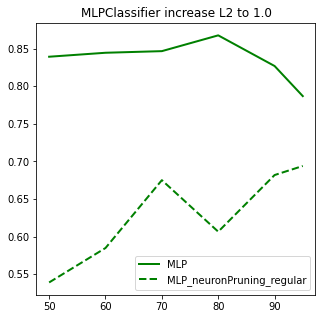

In [43]:
%%time

f1_MLP2 = []
f1_MLP_prune_reg2 = []

## Going to use sklearn's StandardScaler for the training and testing
for train_size in train_size_split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size/100, shuffle=True, random_state=0)
    
    ## MLP no pruning, default hidden_layer_sizes (100,)
    MLP_pipeline_ = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', MLPClassifier())
    ])
    MLP_pipeline_.fit(X_train, y_train)
    MLP_y_pred = MLP_pipeline_.predict(X_test)
    f1_MLP2.append(f1_score(y_test, MLP_y_pred))
    
    ## MLP neuron pruning and regularization 
    ## hidden_layer_sizes: (20, 10) and l2: 1
    MLP_pipeline_Prune_Reg = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                     alpha=1.0))
    ])
    MLP_pipeline_Prune_Reg.fit(X_train, y_train)
    MLP_prune_reg_y_pred = MLP_pipeline_Prune_Reg.predict(X_test)
    f1_MLP_prune_reg2.append(f1_score(y_test, MLP_prune_reg_y_pred))

df_scoring2 = pd.DataFrame({'Train_Size %': train_size_split,
                            'MLP_f1': f1_MLP2,
                            'MLP_f1_neuronPruning_regular': f1_MLP_prune_reg2
                           })

fig = plt.figure(figsize=(5,5))
ax3 = plt.subplot(111)
ax3.plot(df_scoring2['Train_Size %'], df_scoring2['MLP_f1'], linestyle='-', linewidth=2, color='green', label='MLP')
ax3.plot(df_scoring2['Train_Size %'], df_scoring2['MLP_f1_neuronPruning_regular'], linestyle='--', linewidth=2, color='green', label='MLP_neuronPruning_regular')
ax3.legend(loc='best')
ax3.set_title('MLPClassifier increase L2 to 1.0')

That seemed to make it worse. Let's keep the same single hidden layer and just try with decreasing and increasing alpha.

Wall time: 9min 52s


Text(0.5, 1.0, 'MLPClassifier increase and decrease L2\nEqual Single Hidden Layer')

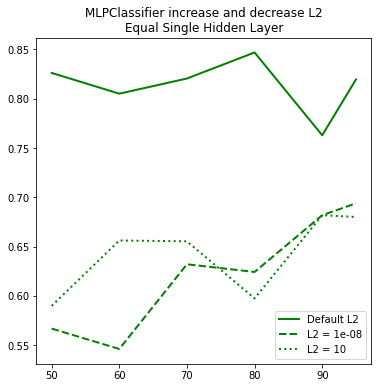

In [47]:
%%time

f1_MLP_low_l2 = []
f1_MLP_default_l2 = []
f1_MLP_high_l2 = []

## Going to use sklearn's StandardScaler for the training and testing
for train_size in train_size_split:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size/100, shuffle=True, random_state=0)
    
    ## MLP default alpha
    MLP_pipeline_ = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', MLPClassifier())
    ])
    MLP_pipeline_.fit(X_train, y_train)
    MLP_y_pred = MLP_pipeline_.predict(X_test)
    f1_MLP_default_l2.append(f1_score(y_test, MLP_y_pred))
    
    ## MLP neuron regularization 
    ## l2: 1e-08
    MLP_pipeline_Low_Reg = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', MLPClassifier(alpha=1e-08))
    ])
    MLP_pipeline_Prune_Reg.fit(X_train, y_train)
    MLP_prune_reg_y_pred = MLP_pipeline_Prune_Reg.predict(X_test)
    f1_MLP_low_l2.append(f1_score(y_test, MLP_prune_reg_y_pred))
    
    ## MLP neuron regularization 
    ## l2: 10
    MLP_pipeline_Low_Reg = Pipeline([
        ('scale', StandardScaler()),
        ('classifier', MLPClassifier(alpha=10))
    ])
    MLP_pipeline_Prune_Reg.fit(X_train, y_train)
    MLP_prune_reg_y_pred = MLP_pipeline_Prune_Reg.predict(X_test)
    f1_MLP_high_l2.append(f1_score(y_test, MLP_prune_reg_y_pred))
    

df_scoring3 = pd.DataFrame({'Train_Size %': train_size_split,
                            'f1_MLP_default_l2': f1_MLP_default_l2,
                            'f1_MLP_low_l2': f1_MLP_low_l2,
                            'f1_MLP_high_l2': f1_MLP_high_l2,
                            })

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(111)
ax1.plot(df_scoring3['Train_Size %'], df_scoring3['f1_MLP_default_l2'], linestyle='-', linewidth=2, color='green', label='Default L2')
ax1.plot(df_scoring3['Train_Size %'], df_scoring3['f1_MLP_low_l2'], linestyle='--', linewidth=2, color='green', label='L2 = 1e-08')
ax1.plot(df_scoring3['Train_Size %'], df_scoring3['f1_MLP_high_l2'], linestyle=':', linewidth=2, color='green', label='L2 = 10')
ax1.legend(loc='best')
ax1.set_title('MLPClassifier increase and decrease L2\nEqual Single Hidden Layer')

Interesting it looks like changing the default `L2` makes it worse higher whether making it higher or lower.  I wonder if this default `L2` is optimized.  I may look up some writing on this topic.